In [2]:
import pandas as pd
import numpy as np
import nltk, spacy, scipy, sklearn, re, math, string, os, csv, json, ast, sys, itertools
from datetime import datetime, date
import matplotlib.pyplot as plt

from nltk.tokenize import RegexpTokenizer
from collections import Counter

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Loneliness and Gender on Twitter

The code below was used in the data analysis in the following paper: 

"Gender in the Disclosure of Loneliness on Twitter during COVID-19 Lockdowns" by Yelena Mejova and Anya Hommadova Lu

In submission to the Special issue of Frontiers in Digital Health in Virtual Presence: Loneliness, technology and the production of human (dis)connectedness:
    
https://www.frontiersin.org/research-topics/46460/virtual-presence-loneliness-technology-and-the-production-of-human-disconnectedness

## Original Data Collection

The data was collected using the Twitter Streaming API with the keywords "lonely" and "loneliness". Due to the sensitive nature of the dataset, and the Twitter Terms of Service, the data cannot be publicly shared. For more information, please contact the lead author Yelena Mejova <yelenamejova@acm.org>.

The data has already been classified as self-disclosure. For more information on this process, see 

Hommadova Lu, Anya, and Yelena Mejova. "All the lonely people: Effects of social isolation on self-disclosure of loneliness on Twitter." New Media & Society (2022): 14614448221099900.

# Gender classification

The classification is done using a few heuristics and mostly by matching the user name to the name list of the US Social Security and the National Records of Scotland, supplemented by user names from Google+ (see paper for citations). The output may contain several gender guesses. For this study, we use only users with names which were unambiguously matched to one gender.

In [ ]:
# English language gender identifier using name dictionaries
honorifics = ("master","mr","miss","mrs","ms","mx","sir","sire","mistress","madam","ma","am","dame","lord","lady","the","dr","doctor","prof","professor","fr","pr","br","sr","rt","rabbi","canon","cheif","sister","brother","reverend","major","cllr","viscount","viscountess","baron","baroness","capitain","mp","uncle","aunt","cousin","mother","father")
stopwords = ("about","above","after","again","against","all","am","an","and","any","are","as","at","be","because","been","before","being","below","between","both","but","by","cannot","could","did","do","does","doing","down","during","each","few","for","from","further","had","has","have","having","he","her","here","hers","herself","him","himself","his","how","i","if","in","into","is","it","its","itself","me","more","most","my","myself","no","nor","not","of","off","on","once","only","or","other","ought","our","ours","ourselves","out","over","own","same","she","should","so","some","such","than","that","the","their","theirs","them","themselves","then","there","these","they","this","those","through","to","too","under","until","up","very","was","we","were","what","when","where","which","while","who","whom","why","with","would","you","your","yours","yourself","yourselves")

genderindicators_female_prefix = ("ms","mrs","miss","madam","maam")
genderindicators_female_words = ("sister","aunt","mother","mom","girl","woman","grandma","grandmom","grandmother","niece","lady","dame","gal")
genderindicators_male_prefix = ("mr","sir","sire","lord")
genderindicators_male_words = ("brother","uncle","father","dad","grandpa","grandfather","granddad","man","boy","nephew","guy")

# English language names
namegenderdic = dict()
fin = open("../Gender/gender_extractor/gabrielNameDictionary.txt",'r')
for line in fin:
    parts = line.strip().split('\t')
    namegenderdic[parts[0]] = "f" if parts[1] == "female" else "m"
fin.close()
fin = open("../Gender/gender_extractor/names_distinct_gender.txt",'r')
for line in fin:
    parts = line.strip().split('\t')
    namegenderdic[parts[0]] = parts[1]
fin.close()

# Russian language names


# Ukrainian language names



def matchnamegender (text):
    firstname = ""
    genderindicator = ""
    genderindicatordic = ""
    overall = ""
    i = 0

    try:
        namestring = text.lower().replace("_"," ")
        possiblenames = re.findall(r"\w+", namestring)

        for w in possiblenames:
            if len(w) > 1 and not (w in honorifics) and not (w in stopwords) and firstname == "":
                # Replace any letter repeating more than 2 times with 1
                w = re.sub(r'(.)\1{2,}', r'\1', w)
                firstname = w
            if i == 0 and (w in genderindicators_female_prefix):
                genderindicator += "f"
            if i == 0 and (w in genderindicators_male_prefix):
                genderindicator += "m"
            if w in genderindicators_female_words:
                genderindicator += "f"
            if w in genderindicators_male_words:
                genderindicator += "m"
            i += 1

        if not firstname == "":
            if firstname in namegenderdic:
                genderindicatordic = namegenderdic[firstname]

        if genderindicatordic == "f" and genderindicator != "m":
            overall = "f"
        if genderindicatordic == "m" and genderindicator != "f":
            overall = "m"
        if genderindicatordic == "":
            overall = genderindicator
        if overall == "":
            overall = "u"

        return overall # genderindicator +"\t"+ genderindicatordic

    except:
        return None

In [7]:
# Spam blacklist (compiled on Oct 20, 2021)
spam = "|".join(["need of a sugar baby with good behavior and good sense of humour", 
                 "no nudes, no sex", "sugarbabywanted", "erotic", "sugardaddy", "amateur", 
                 "sugarmommy", "escort", "milfs", "webcam", "cam", "bbw", "sugarbabieswanted", 
                 "sugarbabylife", "sugarbabies", "busty", "sugarbaby", "dirty", "lauv", 
                 "dating services", "xxx", "vixx", "blowjob", "sugarbabytwitter", "sugarbabies", 
                 "nude", "sugardaddywanted", "sexual", "alessia", "milf", "milfs", "fckin",
                 "cuffed", "bigtits", "fck", "choke", "naked", "pornhub", "sugar baby"])

In [10]:
folder = "../Classified_2years/"
filenames = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
filenames.sort()
filename_out_before = "../Gender/data/filtered_before.tsv"
filename_out_during = "../Gender/data/filtered_during.tsv"
beforeCOVID = True
afterCOVID = False

for filename in filenames:
    if filename == "20200315_lonely.tsv.gz":
        beforeCOVID = False
        afterCOVID = True
    a = pd.read_csv(os.path.join(folder, filename), sep="\t", lineterminator='\n', 
            low_memory=False, quoting=csv.QUOTE_NONE, escapechar=None, header=None, 
            names=["text", "id", "created_at", "place", "truncated", "is_quote_status", "retweeted", 
              "favorite_count", "retweet_count", "geo", "lang", "hashtags", "retweeted_status_id", 
              "retweeted_status_user_id", "retweeted_status_user_screen_name", "retweeted_extended_tweet", 
              "user_id", "user_name", "user_screen_name", "user_followers_count", 
              "user_friends_count", "user_favourites_count", 
              "user_listed_count", "user_statuses_count", "user_description", 
              "user_location", "user_created_at", "utc_offset", 
              "gender", "text_clean", "f_direct", "f_caps", "f_punct"],
            dtype={'id': str, 'retweeted_status_user_id': str, 'retweeted_status_id': str,
                   'user_id': str, 'retweet_count': str})

    a = a[~a.text.str.startswith("RT ")]
    a = a[a.retweeted_status_id.isnull()]
    a = a[~a.text_clean.str.contains(spam, case=False, na=False)]
    a = a[((a.gender=="f") | (a.gender=="m"))]
    # Deduplicate on clean content field
    a = a.drop_duplicates(subset="text_clean")
    if beforeCOVID:
        a.to_csv(filename_out_before, mode='a', header=False, index=False, sep="\t")
    if afterCOVID:
        a.to_csv(filename_out_during, mode='a', header=False, index=False, sep="\t")
    print (filename, str(a.shape[0]))

20190315_lonely.tsv.gz 3996
20190316_lonely.tsv.gz 4389
20190317_lonely.tsv.gz 4598
20190318_lonely.tsv.gz 4358
20190319_lonely.tsv.gz 4444
20190320_lonely.tsv.gz 4074
20190321_lonely.tsv.gz 4565
20190322_lonely.tsv.gz 4457
20190323_lonely.tsv.gz 4458
20190324_lonely.tsv.gz 4821
20190325_lonely.tsv.gz 4436
20190326_lonely.tsv.gz 4234
20190327_lonely.tsv.gz 4595
20190328_lonely.tsv.gz 4118
20190329_lonely.tsv.gz 4146
20190330_lonely.tsv.gz 4308
20190331_lonely.tsv.gz 4332
20190401_lonely.tsv.gz 4062
20190402_lonely.tsv.gz 4104
20190403_lonely.tsv.gz 4125
20190404_lonely.tsv.gz 4055
20190405_lonely.tsv.gz 4103
20190406_lonely.tsv.gz 4251
20190407_lonely.tsv.gz 4284
20190408_lonely.tsv.gz 4291
20190409_lonely.tsv.gz 4305
20190410_lonely.tsv.gz 4051
20190411_lonely.tsv.gz 4153
20190412_lonely.tsv.gz 4593
20190413_lonely.tsv.gz 4258
20190414_lonely.tsv.gz 4453
20190415_lonely.tsv.gz 4244
20190416_lonely.tsv.gz 4071
20190417_lonely.tsv.gz 4234
20190418_lonely.tsv.gz 4216
20190419_lonely.tsv.

20200102_lonely.tsv.gz 4569
20200103_lonely.tsv.gz 4289
20200104_lonely.tsv.gz 4498
20200105_lonely.tsv.gz 4659
20200106_lonely.tsv.gz 4628
20200107_lonely.tsv.gz 4439
20200108_lonely.tsv.gz 4228
20200109_lonely.tsv.gz 4861
20200110_lonely.tsv.gz 4473
20200111_lonely.tsv.gz 4724
20200112_lonely.tsv.gz 4863
20200113_lonely.tsv.gz 4680
20200114_lonely.tsv.gz 4615
20200115_lonely.tsv.gz 4643
20200116_lonely.tsv.gz 4442
20200117_lonely.tsv.gz 4661
20200118_lonely.tsv.gz 4120
20200119_lonely.tsv.gz 2167
20200120_lonely.tsv.gz 4918
20200121_lonely.tsv.gz 4671
20200122_lonely.tsv.gz 4471
20200123_lonely.tsv.gz 4551
20200124_lonely.tsv.gz 4560
20200125_lonely.tsv.gz 4663
20200126_lonely.tsv.gz 4708
20200127_lonely.tsv.gz 4018
20200128_lonely.tsv.gz 4397
20200129_lonely.tsv.gz 4744
20200130_lonely.tsv.gz 4618
20200131_lonely.tsv.gz 4553
20200201_lonely.tsv.gz 4757
20200202_lonely.tsv.gz 5009
20200203_lonely.tsv.gz 5021
20200204_lonely.tsv.gz 4539
20200205_lonely.tsv.gz 4646
20200206_lonely.tsv.

20201021_lonely.tsv.gz 6046
20201022_lonely.tsv.gz 5431
20201023_lonely.tsv.gz 5897
20201024_lonely.tsv.gz 6175
20201025_lonely.tsv.gz 7010
20201026_lonely.tsv.gz 6383
20201027_lonely.tsv.gz 6283
20201028_lonely.tsv.gz 5382
20201029_lonely.tsv.gz 6003
20201030_lonely.tsv.gz 6251
20201031_lonely.tsv.gz 6129
20201101_lonely.tsv.gz 6528
20201102_lonely.tsv.gz 6326
20201103_lonely.tsv.gz 5809
20201104_lonely.tsv.gz 5092
20201105_lonely.tsv.gz 5731
20201106_lonely.tsv.gz 6018
20201107_lonely.tsv.gz 6130
20201108_lonely.tsv.gz 6672
20201109_lonely.tsv.gz 6610
20201110_lonely.tsv.gz 6616
20201111_lonely.tsv.gz 6558
20201112_lonely.tsv.gz 6609
20201113_lonely.tsv.gz 6223
20201114_lonely.tsv.gz 6286
20201115_lonely.tsv.gz 6780
20201116_lonely.tsv.gz 6850
20201117_lonely.tsv.gz 6640
20201118_lonely.tsv.gz 6744
20201119_lonely.tsv.gz 6314
20201120_lonely.tsv.gz 6245
20201121_lonely.tsv.gz 6336
20201122_lonely.tsv.gz 6646
20201123_lonely.tsv.gz 6924
20201124_lonely.tsv.gz 6349
20201125_lonely.tsv.

In [3]:
# Loading already cleaned data
data_b = pd.read_csv("../Gender/data/filtered_before.tsv", sep="\t", lineterminator='\n',   # _230328
                    low_memory=False, quoting=csv.QUOTE_NONE, escapechar=None, header=None, 
            names=["text", "id", "created_at", "place", "truncated", "is_quote_status", "retweeted", 
              "favorite_count", "retweet_count", "geo", "lang", "hashtags", "retweeted_status_id", 
              "retweeted_status_user_id", "retweeted_status_user_screen_name", "retweeted_extended_tweet", 
              "user_id", "user_name", "user_screen_name", "user_followers_count", 
              "user_friends_count", "user_favourites_count", 
              "user_listed_count", "user_statuses_count", "user_description", 
              "user_location", "user_created_at", "utc_offset", 
              "gender", "text_clean", "f_direct", "f_caps", "f_punct"],
            dtype={'id': str, 'retweeted_status_user_id': str, 'retweeted_status_id': str,
                   'user_id': str, 'retweet_count': str})
data_b["covid"] = 0

In [4]:
data_d = pd.read_csv("../Gender/data/filtered_during.tsv", sep="\t", lineterminator='\n',   # _230328
                    low_memory=False, quoting=csv.QUOTE_NONE, escapechar=None, header=None, 
            names=["text", "id", "created_at", "place", "truncated", "is_quote_status", "retweeted", 
              "favorite_count", "retweet_count", "geo", "lang", "hashtags", "retweeted_status_id", 
              "retweeted_status_user_id", "retweeted_status_user_screen_name", "retweeted_extended_tweet", 
              "user_id", "user_name", "user_screen_name", "user_followers_count", 
              "user_friends_count", "user_favourites_count", 
              "user_listed_count", "user_statuses_count", "user_description", 
              "user_location", "user_created_at", "utc_offset", 
              "gender", "text_clean", "f_direct", "f_caps", "f_punct"],
            dtype={'id': str, 'retweeted_status_user_id': str, 'retweeted_status_id': str,
                   'user_id': str, 'retweet_count': str})
data_d["covid"] = 1

In [6]:
data = pd.concat([data_d, data_b], ignore_index=True)
data.shape

(3766457, 34)

### Data cleaning

To make sure only self-disclosures are included in the data, additional keywords are excluded from the dataset, mostly those that have a repeating pattern (likely to be spam) or those referring to songs that mention loneliness (in this study, we define such songs as not explicit self-disclosure, though this could be argued). 

In [9]:
# Remove exact duplicates 
data = data.drop_duplicates(subset="text_clean")

In [10]:
# Remove posts with URLs
data = data[~data.text.str.contains("http")]

In [7]:
toremove = "What I Should Have Said Was Loneliness, Not Arrogance, But I Couldn't Do That. I Didn't Want To Wound His Pride."
data = data[~data.text.str.contains(toremove, case=False, na=False)]
toremove = "one of the biggest leadership myths it's lonely at the top"
data = data[~data.text_clean.str.contains(toremove, case=False, na=False)]
toremove = "Taeyeon and Tiffany used to be together in their dorm while the other members were leaving"
data = data[~data.text.str.contains(toremove, case=False, na=False)]

In [11]:
# Remove automated posts
data = data[~data.text.str.contains("sqkm Population", case=False)]
data = data[~data.text.str.contains("stumbled upon a fairy fountain", case=False)]
data = data[~data.text.str.contains("oppa", case=False)]
data = data[~data.text.str.contains("snapme", case=False)]
data = data[~data.text.str.contains("hyung", case=False)]
data = data[~data.text.str.contains("It’s lonely at the top", case=False)]
data = data[~data.text.str.contains("hbsmith16", case=False)]
data = data[~data.text.str.contains("hea", case=False)]
data = data[~data.text.str.contains("noah", case=False)]
data = data[~data.text.str.contains("cyrus", case=False)]
data = data[~data.text.str.contains("svt", case=False)]
data = data[~data.text.str.contains("vmin", case=False)]
data = data[~data.text_clean.str.contains("sgt pepper", case=False)]
data = data[~data.text.str.contains("Lonely Oak Radio", case=False)]
data = data[~data.text_clean.str.contains(" dey ", case=False)]
data = data[~data.text.str.contains("Sinned", case=False)]
data = data[~data.text.str.contains("yoongi", case=False)]
data = data[~data.text.str.contains("jungkook", case=False)]
data = data[~data.text_clean.str.contains("lonely mountains downhill", case=False)]
data = data[~data.text_clean.str.contains("the police", case=False)]
data = data[~data.text_clean.str.contains("you can have a thousand friends and still feel lonely", case=False)]
data = data[~data.text_clean.str.contains("lonely as a cloud", case=False)]
data = data[~data.text.str.contains("2ne1 ", case=False)]
data = data[~data.text_clean.str.contains(" stan ", case=False)]

In [13]:
# Users likely to be spammers/bots
users_to_remove = pd.read_csv("../Gender/data/users_to_remove_16.csv")

In [14]:
# Remove over-active users (computed below)
data = data[~data.user_id.isin(users_to_remove.user_id.astype(str))]
data.shape

(1600815, 34)

In [15]:
data = data[data.user_id != "969398693249126400"]   # Random Goth Lyric Generator

In [661]:
data.drop_duplicates(subset="user_id").gender.value_counts()

f    664423
m    576538
Name: gender, dtype: int64

In [662]:
data[["id", "user_id", "gender"]].to_csv("../Gender/data/_loneliness_gender_public_dataset_frontiers.csv", index=False)

In [39]:
data[["user_id", "user_location"]].to_csv("../Gender/data/_user_locations.csv", index=False)

In [16]:
data.lang.value_counts()

en    1600359
Name: lang, dtype: int64

# Volume over time

The volume of posting is computed per user, such that the cases where one user posts excessively does not overwhelm the statistic. Further, the collection sometimes went down due to technical difficulties. For such days, we interpolate the rate using the posting rates around that time.

### Date variables

In [17]:
data["created_at_datetime"] = pd.to_datetime(data.created_at, format='%a %b %d %H:%M:%S +0000 %Y', errors = "coerce")
data["created_at_datetime"] = data["created_at_datetime"] - pd.DateOffset(hours=6) # time from gmt to us central time
data["created_at_date"] = data["created_at_datetime"].dt.date

In [18]:
data["lockdown"] = data["created_at_date"].apply(lambda x: 1 if ((x > date(2020, 3, 22)) & (x < date(2020, 6, 1))) else 0)

In [19]:
# Tweets per gender per user, without de-duplication
daycounts_f_nodedup = data[data.gender=="f"].groupby("user_id", as_index=False).id.count()
daycounts_m_nodedup = data[data.gender=="m"].groupby("user_id", as_index=False).id.count()
print (str(daycounts_f_nodedup.id.mean()) + "  " + str(daycounts_m_nodedup.id.mean()))

1.2930375749685346  1.262105735367671


In [20]:
daycounts_f_nodedup.id.mean()

1.2930375749685346

In [21]:
daycounts_m_nodedup.id.mean()

1.262105735367671

In [22]:
daycounts_f_nodedup.id.std()

1.0125568211901288

In [23]:
daycounts_m_nodedup.id.std()

0.9835832316404002

In [24]:
scipy.stats.mannwhitneyu(daycounts_f_nodedup.id, daycounts_m_nodedup.id)

MannwhitneyuResult(statistic=198223627138.0, pvalue=3.824237393021666e-151)

In [25]:
# Remove tweets within the same day by the same user (counting unique users posting in a day)
data_u = data.drop_duplicates(subset=["created_at_date", "user_id"])
data_u.shape

(1558151, 37)

In [26]:
daycounts_f = data_u[data_u.gender=="f"].groupby("created_at_date", as_index=False).id.count()
daycounts_m = data_u[data_u.gender=="m"].groupby("created_at_date", as_index=False).id.count()

In [27]:
daycounts_f["covid"] = daycounts_f["created_at_date"].apply(lambda x: 0 if x < date(2020, 3, 15) else 1)
daycounts_m["covid"] = daycounts_m["created_at_date"].apply(lambda x: 0 if x < date(2020, 3, 15) else 1)

In [28]:
# Check days when we have data (exclude days with 2+ missing hours)
missing_days = pd.read_csv("../Statistics/missing_days.txt")
missing_days = missing_days[missing_days.hours_missing>1]

In [29]:
daycounts_f.loc[daycounts_f.created_at_date.isin(missing_days.date),"h"] = None
daycounts_m.loc[daycounts_m.created_at_date.isin(missing_days.date),"h"] = None

In [30]:
daycounts_f["interpolated"] = daycounts_f["id"].interpolate()
daycounts_m["interpolated"] = daycounts_m["id"].interpolate()

In [31]:
daycounts_f = daycounts_f.set_index("created_at_date")
daycounts_m = daycounts_m.set_index("created_at_date")

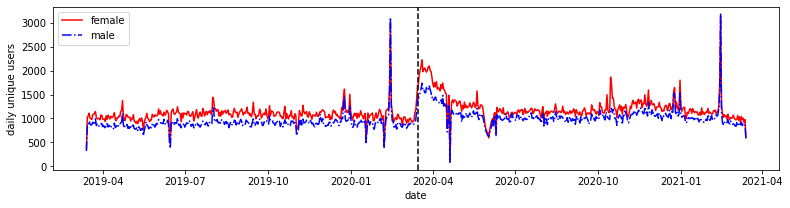

In [32]:
ax = daycounts_f.interpolated.plot(figsize=(13,3), color="r", label="female")
ax.set(xlabel="date", ylabel="daily unique users")
ax.axvline(pd.to_datetime('2020-03-15'), color='k', linestyle='--')
ax.plot(daycounts_f.index, daycounts_m.interpolated, 'b-.', label="male")
ax.legend(loc='best')

In [35]:
ax.figure.savefig('../Gender/figures/lonely_gender_user_counts_by_day_3_aftercleaning2.pdf', bbox_inches="tight")

In [674]:
scipy.stats.pearsonr(daycounts_f.interpolated, daycounts_m.interpolated)

(0.9449494379642691, 0.0)

In [675]:
# Average daily users 
print("mean Female: {:.1f} std: {:.1f}".format(daycounts_f.id.mean(), daycounts_f.id.std()))
print("mean Male: {:.1f} std: {:.1f}".format(daycounts_m.id.mean(), daycounts_m.id.std()))

mean Female: 1152.9 std: 234.7
mean Male: 978.7 std: 204.3


In [676]:
# Average daily users before covid
print("mean Female: {:.1f} std: {:.1f}".format(daycounts_f[daycounts_f.covid==0].id.mean(), daycounts_f[daycounts_f.covid==0].id.std()))
print("mean Male: {:.1f} std: {:.1f}".format(daycounts_m[daycounts_m.covid==0].id.mean(), daycounts_m[daycounts_m.covid==0].id.std()))

mean Female: 1074.5 std: 157.1
mean Male: 897.3 std: 157.3


In [677]:
# Average daily users during covid
print("mean Female: {:.1f} std: {:.1f}".format(daycounts_f[daycounts_f.covid==1].id.mean(), daycounts_f[daycounts_f.covid==1].id.std()))
print("mean Male: {:.1f} std: {:.1f}".format(daycounts_m[daycounts_m.covid==1].id.mean(), daycounts_m[daycounts_m.covid==1].id.std()))

mean Female: 1231.5 std: 270.9
mean Male: 1060.3 std: 213.4


In [678]:
# Average daily users during first 2 weeks of lockdowns
print("mean Female: {:.1f} std: {:.1f}".format(daycounts_f[daycounts_f.covid==1].id.mean(), daycounts_f[daycounts_f.covid==1].id.std()))
print("mean Male: {:.1f} std: {:.1f}".format(daycounts_m[daycounts_m.covid==1].id.mean(), daycounts_m[daycounts_m.covid==1].id.std()))

mean Female: 1231.5 std: 270.9
mean Male: 1060.3 std: 213.4


In [679]:
# Statistical test before vs after COVID (independent two-sided T test)
scipy.stats.ttest_ind(daycounts_f[daycounts_f.covid==1].id, daycounts_f[daycounts_f.covid==0].id)

Ttest_indResult(statistic=9.58728119924399, pvalue=1.3918692028276803e-20)

In [680]:
scipy.stats.ttest_ind(daycounts_m[daycounts_m.covid==1].id, daycounts_m[daycounts_m.covid==0].id)

Ttest_indResult(statistic=11.755687181972826, pvalue=2.4353760881762459e-29)

In [681]:
# Statistical test between men and women (independent two-sided T test)
scipy.stats.ttest_ind(daycounts_f[daycounts_f.covid==0].id, daycounts_m[daycounts_m.covid==0].id)

Ttest_indResult(statistic=15.243542147083156, pvalue=9.345107032278648e-46)

In [682]:
scipy.stats.ttest_ind(daycounts_f[daycounts_f.covid==1].id, daycounts_m[daycounts_m.covid==1].id)

Ttest_indResult(statistic=9.483007633027535, pvalue=3.41264194951555e-20)

In [683]:
# Average daily users week before covid
s = daycounts_f[(daycounts_f.index < date(2020, 3, 15)) & (daycounts_f.index > date(2020, 3, 7))]
print("mean Female: {:.1f} std: {:.1f}".format(s.id.mean(), s.id.std()))
s = daycounts_m[(daycounts_m.index < date(2020, 3, 15)) & (daycounts_m.index > date(2020, 3, 7))]
print("mean Male: {:.1f} std: {:.1f}".format(s.id.mean(), s.id.std()))

mean Female: 1061.9 std: 172.0
mean Male: 937.0 std: 113.1


In [684]:
# Average daily users week during covid
s = daycounts_f[(daycounts_f.index >= date(2020, 3, 15)) & (daycounts_f.index < date(2020, 3, 22))]
print("mean Female: {:.1f} std: {:.1f}".format(s.id.mean(), s.id.std()))
s = daycounts_m[(daycounts_m.index >= date(2020, 3, 15)) & (daycounts_m.index < date(2020, 3, 22))]
print("mean Male: {:.1f} std: {:.1f}".format(s.id.mean(), s.id.std()))

mean Female: 1950.9 std: 195.2
mean Male: 1537.3 std: 123.1


### Difference in volume of two genders

In [567]:
daycounts_f["diff_f_m_interpol"] = daycounts_f["interpolated"] - daycounts_m["interpolated"]

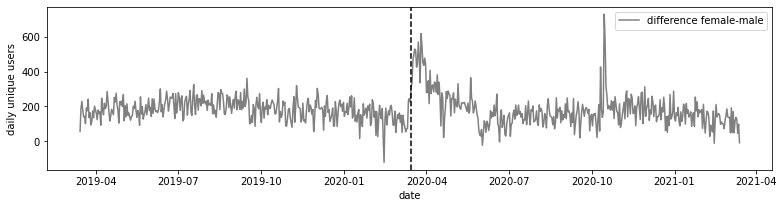

In [568]:
ax = daycounts_f.diff_f_m_interpol.plot(figsize=(13,3), color="grey", label="difference female-male")
ax.set(xlabel="date", ylabel="daily unique users")
ax.axvline(pd.to_datetime('2020-03-15'), color='k', linestyle='--')
ax.legend(loc='best')

In [569]:
ax.figure.savefig('../Gender/figures/lonely_gender_user_counts_by_day_diff.png')

In [570]:
# Check the peaks
daycounts_f.sort_values(by="diff_f_m_interpol", ascending=False).head(10)

,id,covid,h,interpolated,diff_f_m_interpol
created_at_date,,,,,
2020-10-15,1959,1,NaN,1959,731
2020-03-26,2386,1,NaN,2386,619
2020-10-16,1847,1,NaN,1847,580
2020-03-23,2179,1,NaN,2179,571
2020-03-27,2267,1,NaN,2267,551
2020-03-19,2204,1,NaN,2204,530
2020-03-20,2322,1,NaN,2322,522
2020-03-18,2104,1,NaN,2104,497
2020-03-24,2090,1,NaN,2090,478


# Content Analysis

Content analysis consists of considering separately the posts by male and by female users, and also separately for before and during COVID periods. The text is tokenized, stopwords are removed, and the Odds Ratio is computed on the resulting rates, with an application of additive smoothing so that words that have not appeared in one of the sets (such as "covid") are not "wiped out" due to a 0 frequency.

## Top words

In [120]:
tokenizer = RegexpTokenizer(r'\w+')

In [198]:
# Remove emoticons
data["text_clean"] = data["text_clean"].str.replace(r':.*:', '', regex=True)

In [223]:
data["text_tokens"] = data["text_clean"].apply(lambda x: tokenizer.tokenize(x))

In [327]:
wc_b_f = Counter(tokenizer.tokenize(data[(data.gender=="f") & (data.covid==0)].text_clean.str.cat(sep=' ')))
wc_d_f = Counter(tokenizer.tokenize(data[(data.gender=="f") & (data.covid==1)].text_clean.str.cat(sep=' ')))
wc_b_m = Counter(tokenizer.tokenize(data[(data.gender=="m") & (data.covid==0)].text_clean.str.cat(sep=' ')))
wc_d_m = Counter(tokenizer.tokenize(data[(data.gender=="m") & (data.covid==1)].text_clean.str.cat(sep=' ')))

In [328]:
wc_b_f = pd.DataFrame(list(dict(wc_b_f.most_common()).items()), columns=["word","before_f"])
wc_d_f = pd.DataFrame(list(dict(wc_d_f.most_common()).items()), columns=["word","during_f"])
wc_b_m = pd.DataFrame(list(dict(wc_b_m.most_common()).items()), columns=["word","before_m"])
wc_d_m = pd.DataFrame(list(dict(wc_d_m.most_common()).items()), columns=["word","during_m"])

In [329]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
wc_b_f = wc_b_f[~wc_b_f.word.isin(stop)]
wc_d_f = wc_d_f[~wc_d_f.word.isin(stop)]
wc_b_m = wc_b_m[~wc_b_m.word.isin(stop)]
wc_d_m = wc_d_m[~wc_d_m.word.isin(stop)]
wc_b_f = wc_b_f[wc_b_f.word.str.len()>2]
wc_d_f = wc_d_f[wc_d_f.word.str.len()>2]
wc_b_m = wc_b_m[wc_b_m.word.str.len()>2]
wc_d_m = wc_d_m[wc_d_m.word.str.len()>2]

In [330]:
wc_b_f["gender"] = "f"
wc_d_f["gender"] = "f"
wc_b_m["gender"] = "m"
wc_d_m["gender"] = "m"

In [331]:
print("Before F: " + ", ".join(list(wc_b_f.head(20).word)))
print("Before M: " + ", ".join(list(wc_b_m.head(20).word)))
print("After F: " + ", ".join(list(wc_d_f.head(20).word)))
print("After M: " + ", ".join(list(wc_d_m.head(20).word)))

Before F: lonely, feel, like, feeling, friends, sad, loneliness, get, one, really, want, people, someone, time, alone, life, need, love, know, amp
Before M: lonely, feel, like, loneliness, feeling, get, sad, one, friends, people, really, life, want, time, someone, alone, need, know, day, love
After F: lonely, feel, like, feeling, loneliness, friends, sad, get, one, want, really, people, time, alone, someone, need, know, love, life, day
After M: lonely, feel, like, loneliness, feeling, get, sad, one, friends, people, want, really, time, alone, life, someone, know, need, day, love


In [382]:
len(set(wc_b_f.head(100).word).intersection(set(wc_b_m.head(100).word)))

92

In [383]:
len(set(wc_d_f.head(100).word).intersection(set(wc_d_m.head(100).word)))

91

## Odds Ratio: Before COVID F vs M

In [332]:
oddsratiocut = 1.5 # Odds ratio at least of 1.5 (50% more likely to happen)
wordnumcut = 100   # Top 100 words to examine

In [413]:
wordtable = pd.merge(wc_b_f, wc_b_m, on="word", how="outer").fillna(0)
wordtable["before_f_not"] = wordtable["before_f"].sum() - wordtable["before_f"]
wordtable["before_m_not"] = wordtable["before_m"].sum() - wordtable["before_m"]

In [414]:
alpha = 1  # for additive smoothing https://en.wikipedia.org/wiki/Additive_smoothing
freqcut_1 = 50
freqcut_2 = 0
wordtable["oddsratio"] = ((wordtable['before_f']+alpha) * (wordtable['before_m_not']+alpha)) / ((wordtable['before_m']+alpha) * (wordtable['before_f_not']+alpha))

In [415]:
pd.set_option('display.max_rows', 100)
wordtable = wordtable.sort_values(by = "oddsratio", ascending=False)
wordtable[(wordtable.before_f >= freqcut_1) & (wordtable.before_m >= freqcut_2)].head(wordnumcut)
# More likely to be used by Female before COVID

,word,before_f,gender_x,before_m,gender_y,before_f_not,before_m_not,oddsratio
2459,sahm,100.0,f,12.0,m,3230679.0,2594864.0,6.240205
929,pregnancy,411.0,f,55.0,m,3230368.0,2594821.0,5.909689
2919,maternity,77.0,f,10.0,m,3230702.0,2594866.0,5.695344
1552,motherhood,198.0,f,37.0,m,3230581.0,2594839.0,4.206291
3585,gorl,56.0,f,10.0,m,3230723.0,2594866.0,4.161955
3881,toks,51.0,f,10.0,m,3230728.0,2594866.0,3.796866
1904,hubby,146.0,f,35.0,m,3230633.0,2594841.0,3.279729
3821,pinterest,52.0,f,12.0,m,3230727.0,2594864.0,3.274514
2471,boyf,99.0,f,25.0,m,3230680.0,2594851.0,3.089194
3522,youuu,58.0,f,15.0,m,3230721.0,2594861.0,2.961738


In [416]:
temp = wordtable[(wordtable.before_f >= freqcut_1) & (wordtable.before_m >= freqcut_2)]
temp[temp.oddsratio > oddsratiocut].head(wordnumcut)
top_words_FvsM_bC = temp[temp.oddsratio > oddsratiocut].head(wordnumcut)[["word","oddsratio", "before_f", "before_m"]]

In [417]:
top_words_FvsM_bC.to_csv("../Gender/data/top_words_FvsM_bC.csv", index=False)

In [418]:
alpha = 1  # for additive smoothing https://en.wikipedia.org/wiki/Additive_smoothing
wordtable["oddsratio"] = ((wordtable['before_m']+alpha) * (wordtable['before_f_not']+alpha)) / ((wordtable['before_f']+alpha) * (wordtable['before_m_not']+alpha))

In [419]:
freqcut_1 = 0
freqcut_2 = 50
wordtable = wordtable.sort_values(by = "oddsratio", ascending=False)
wordtable[(wordtable.before_f >= freqcut_1) & (wordtable.before_m >= freqcut_2)].head(30)
# More likely to be used by Male before COVID

,word,before_f,gender_x,before_m,gender_y,before_f_not,before_m_not,oddsratio
6369,dap,24.0,f,116.0,m,3230755.0,2594760.0,5.827102
7430,downhill,18.0,f,74.0,m,3230761.0,2594802.0,4.914827
7950,wank,16.0,f,61.0,m,3230763.0,2594815.0,4.540895
6380,grindr,23.0,f,80.0,m,3230756.0,2594796.0,4.202180
6321,cod,24.0,f,79.0,m,3230755.0,2594797.0,3.984287
6249,thugs,24.0,f,74.0,m,3230755.0,2594802.0,3.735262
7304,victory,19.0,f,59.0,m,3230760.0,2594817.0,3.735246
4567,players,39.0,f,110.0,m,3230740.0,2594766.0,3.455149
7170,greatness,19.0,f,54.0,m,3230760.0,2594822.0,3.423969
4138,brexit,46.0,f,128.0,m,3230733.0,2594748.0,3.417415


In [420]:
temp = wordtable[(wordtable.before_f >= freqcut_1) & (wordtable.before_m >= freqcut_2)]
temp[temp.oddsratio > oddsratiocut].head(wordnumcut)
top_words_MvsF_bC = temp[temp.oddsratio > oddsratiocut].head(wordnumcut)[["word","oddsratio", "before_f", "before_m"]]

In [421]:
top_words_MvsF_bC.to_csv("../Gender/data/top_words_MvsF_bC.csv", index=False)

## Odds Ratio: During COVID F vs M

In [781]:
wordtable = pd.merge(wc_d_f, wc_d_m, on="word", how="outer").fillna(0)
wordtable["during_f_not"] = wordtable["during_f"].sum() - wordtable["during_f"]
wordtable["during_m_not"] = wordtable["during_m"].sum() - wordtable["during_m"]

In [782]:
duringalpha = 1  # for additive smoothing https://en.wikipedia.org/wiki/Additive_smoothing
freqcut_1 = 50
freqcut_2 = 0
wordtable["oddsratio"] = ((wordtable['during_f']+alpha) * (wordtable['during_m_not']+alpha)) / ((wordtable['during_m']+alpha) * (wordtable['during_f_not']+alpha))

In [783]:
wordtable = wordtable.sort_values(by = "oddsratio", ascending=False)
wordtable[(wordtable.during_f > freqcut_1) & (wordtable.during_m > freqcut_2)].head(30)
# More likely to be used by Female during COVID

,word,during_f,gender_x,during_m,gender_y,during_f_not,during_m_not,oddsratio
1902,motherhood,194.0,f,27.0,m,3988610.0,3270095.0,5.709728
4144,maternity,61.0,f,8.0,m,3988743.0,3270114.0,5.647758
3131,niall,93.0,f,14.0,m,3988711.0,3270108.0,5.137669
4044,unnie,63.0,f,10.0,m,3988741.0,3270112.0,4.769953
3883,to_bts,68.0,f,11.0,m,3988736.0,3270111.0,4.714060
900,pregnancy,560.0,f,101.0,m,3988244.0,3270021.0,4.509533
3322,sahm,85.0,f,16.0,m,3988719.0,3270106.0,4.147419
4059,bawling,63.0,f,12.0,m,3988741.0,3270110.0,4.036112
4295,miscarriage,57.0,f,11.0,m,3988747.0,3270111.0,3.962532
2217,hubby,154.0,f,32.0,m,3988650.0,3270090.0,3.850805


In [786]:
temp = wordtable[(wordtable.during_f >= freqcut_1) & (wordtable.during_m >= freqcut_2)]
temp[temp.oddsratio > oddsratiocut].head(wordnumcut)
top_words_FvsM_dC = temp[temp.oddsratio > oddsratiocut].head(wordnumcut)[["word","oddsratio", "during_f", "during_m"]]

In [787]:
wordtable["oddsratio"] = ((wordtable['during_m']+alpha) * (wordtable['during_f_not']+alpha)) / ((wordtable['during_f']+alpha) * (wordtable['during_m_not']+alpha))

In [788]:
freqcut_1 = 0
freqcut_2 = 50
wordtable = wordtable.sort_values(by = "oddsratio", ascending=False)
wordtable[(wordtable.during_f > freqcut_1) & (wordtable.during_m > freqcut_2)].head(30)
# More likely to be used by Male during COVID

,word,during_f,gender_x,during_m,gender_y,during_f_not,during_m_not,oddsratio
22780,livelihood,4.0,f,84.0,m,3988800.0,3270038.0,20.736639
22092,debts,4.0,f,75.0,m,3988800.0,3270047.0,18.540943
14221,bitcoin,9.0,f,57.0,m,3988795.0,3270065.0,7.074786
8624,assistance,19.0,f,107.0,m,3988785.0,3270015.0,6.586954
10833,freeiphone,14.0,f,73.0,m,3988790.0,3270049.0,6.017656
6925,warzone,27.0,f,130.0,m,3988777.0,3269992.0,5.706979
8305,easing,20.0,f,92.0,m,3988784.0,3270030.0,5.401973
9250,boner,17.0,f,76.0,m,3988787.0,3270046.0,5.218013
10209,prick,15.0,f,59.0,m,3988789.0,3270063.0,4.574211
5137,sgt,44.0,f,161.0,m,3988760.0,3269961.0,4.391348


In [789]:
temp = wordtable[(wordtable.during_f >= freqcut_1) & (wordtable.during_m >= freqcut_2)]
temp[temp.oddsratio > oddsratiocut].head(wordnumcut)
top_words_MvsF_dC = temp[temp.oddsratio > oddsratiocut].head(wordnumcut)[["word","oddsratio", "during_f", "during_m"]]

## Odds Ratio: Female After vs Before COVID

In [772]:
wordtable = pd.merge(wc_b_f, wc_d_f, on="word", how="outer").fillna(0)
wordtable["before_f_not"] = wordtable["before_f"].sum() - wordtable["before_f"]
wordtable["during_f_not"] = wordtable["during_f"].sum() - wordtable["during_f"]

In [773]:
alpha = 1  # for additive smoothing https://en.wikipedia.org/wiki/Additive_smoothing
freqcut_1 = 0
freqcut_2 = 0
wordtable["oddsratio"] = ((wordtable['during_f']+alpha) * (wordtable['before_f_not']+alpha)) / ((wordtable['before_f']+alpha) * (wordtable['during_f_not']+alpha))

In [774]:
wordtable = wordtable.sort_values(by = "oddsratio", ascending=False)
wordtable[(wordtable.before_f > freqcut_1) & (wordtable.during_f > freqcut_2)].head(30)
# More likely to be used by Female before COVID

,word,before_f,gender_x,during_f,gender_y,before_f_not,during_f_not,oddsratio
9953,lockdown,13.0,f,3718.0,f,3433694.0,3985086.0,228.887487
8093,pandemic,18.0,f,2827.0,f,3433689.0,3985977.0,128.218883
2731,quarantine,93.0,f,8306.0,f,3433614.0,3980498.0,76.230793
4831,covid,40.0,f,3338.0,f,3433667.0,3985466.0,70.163565
52170,mgk,1.0,f,116.0,f,3433706.0,3988688.0,50.360371
82415,quarentine,1.0,f,110.0,f,3433706.0,3988694.0,47.777716
45962,halle,1.0,f,105.0,f,3433706.0,3988699.0,45.625510
26030,acnh,3.0,f,169.0,f,3433704.0,3988635.0,36.587059
7567,zoom,20.0,f,834.0,f,3433687.0,3987970.0,34.235448
31327,vaccine,2.0,f,118.0,f,3433705.0,3988686.0,34.147495


In [775]:
temp = wordtable[(wordtable.before_f >= freqcut_1) & (wordtable.before_f >= freqcut_2)]
temp[temp.oddsratio > oddsratiocut].head(wordnumcut)
top_words_DvsB_F = temp[temp.oddsratio > oddsratiocut].head(wordnumcut)[["word","oddsratio", "before_f", "during_f"]]

In [760]:
wordtable = wordtable.sort_values(by = "oddsratio", ascending=True)
wordtable[(wordtable.before_f > freqcut_1) & (wordtable.during_f > freqcut_2)].head(30)
# More likely to be used by Female before COVID

,word,before_f,gender_x,during_f,gender_y,before_f_not,during_f_not,oddsratio
2353,keanu,116.0,f,1.0,f,3433591.0,3988803.0,0.014715
5573,eroda,32.0,f,1.0,f,3433675.0,3988803.0,0.052171
6740,encyclopedia,24.0,f,1.0,f,3433683.0,3988803.0,0.068866
6746,renewannewithane,24.0,f,1.0,f,3433683.0,3988803.0,0.068866
3213,reeves,73.0,f,5.0,f,3433634.0,3988799.0,0.069796
6863,hunnid,23.0,f,1.0,f,3433684.0,3988803.0,0.071736
7568,azkar,20.0,f,1.0,f,3433687.0,3988803.0,0.081984
3347,thrones,68.0,f,6.0,f,3433639.0,3988798.0,0.087330
8087,omens,18.0,f,1.0,f,3433689.0,3988803.0,0.090614
8744,tacha,16.0,f,1.0,f,3433691.0,3988803.0,0.101274


## Odds Ratio: Male After vs Before COVID

In [767]:
wordtable = pd.merge(wc_b_m, wc_d_m, on="word", how="outer").fillna(0)
wordtable["before_m_not"] = wordtable["before_m"].sum() - wordtable["before_m"]
wordtable["during_m_not"] = wordtable["during_m"].sum() - wordtable["during_m"]

In [768]:
alpha = 1  # for additive smoothing https://en.wikipedia.org/wiki/Additive_smoothing
freqcut_1 = 0
freqcut_2 = 0
wordtable["oddsratio"] = ((wordtable['during_m']+alpha) * (wordtable['before_m_not']+alpha)) / ((wordtable['before_m']+alpha) * (wordtable['during_m_not']+alpha))

In [769]:
wordtable = wordtable.sort_values(by = "oddsratio", ascending=False)
wordtable[(wordtable.before_m > freqcut_1) & (wordtable.during_m > freqcut_2)].head(50)
# More likely to be used by Female before COVID

,word,before_m,gender_x,during_m,gender_y,before_m_not,during_m_not,oddsratio
11214,lockdown,10.0,m,2399.0,m,2758305.0,3267723.0,184.168620
7468,pandemic,19.0,m,1876.0,m,2758296.0,3268246.0,79.206429
3063,quarantine,71.0,m,6093.0,m,2758244.0,3264029.0,71.523482
4843,covid,36.0,m,2509.0,m,2758279.0,3267613.0,57.263726
35641,warzone,2.0,m,130.0,m,2758313.0,3269992.0,36.833834
76491,lonte,1.0,m,78.0,m,2758314.0,3270044.0,33.318637
81943,quarentine,1.0,m,76.0,m,2758314.0,3270046.0,32.475107
8351,zoom,16.0,m,505.0,m,2758299.0,3269617.0,25.109963
25748,quarantining,3.0,m,111.0,m,2758312.0,3270011.0,23.618496
34611,acnh,2.0,m,82.0,m,2758313.0,3270040.0,23.337125


In [771]:
temp = wordtable[(wordtable.before_m >= freqcut_1) & (wordtable.before_m >= freqcut_2)]
temp[temp.oddsratio > oddsratiocut].head(wordnumcut)
top_words_DvsB_M = temp[temp.oddsratio > oddsratiocut].head(wordnumcut)[["word","oddsratio", "before_m", "during_m"]]

In [764]:
wordtable = wordtable.sort_values(by = "oddsratio", ascending=True)
wordtable[(wordtable.before_m > freqcut_1) & (wordtable.during_m > freqcut_2)].head(30)
# More likely to be used by Male before COVID

,word,before_m,gender_x,during_m,gender_y,before_m_not,during_m_not,oddsratio
2275,keanu,108.0,m,6.0,m,2758207.0,3270116.0,0.054167
3062,reeves,71.0,m,4.0,m,2758244.0,3270118.0,0.058574
2689,sinned,85.0,m,5.0,m,2758230.0,3270117.0,0.058846
6344,loveisland,24.0,m,1.0,m,2758291.0,3270121.0,0.067479
6728,asim,22.0,m,1.0,m,2758293.0,3270121.0,0.073346
6666,phonefuck,22.0,m,1.0,m,2758293.0,3270121.0,0.073346
7194,cindy,20.0,m,1.0,m,2758295.0,3270121.0,0.080332
4575,thrones,39.0,m,3.0,m,2758276.0,3270119.0,0.084348
7387,gng,19.0,m,1.0,m,2758296.0,3270121.0,0.084348
7759,stradlater,18.0,m,1.0,m,2758297.0,3270121.0,0.088788


### How much do top lockdown keywords intersect between the two genders?

In [777]:
top_words_DvsB_both = top_words_DvsB_F.merge(top_words_DvsB_M, on="word")
top_words_DvsB_both
# Words in top 100 that are used by both genders

,word,oddsratio_x,before_f,during_f,oddsratio_y,before_m,during_m
0,lockdown,228.887487,13.0,3718.0,184.168620,10.0,2399.0
1,genshin,148.070185,0.0,171.0,113.875814,0.0,134.0
2,pandemic,128.218883,18.0,2827.0,79.206429,19.0,1876.0
3,quarantinelife,109.329659,0.0,126.0,74.229094,0.0,87.0
4,exabff,108.468769,0.0,125.0,40.488101,0.0,47.0
5,lockdowns,106.746989,0.0,123.0,92.786991,0.0,109.0
6,ticketstomydownfall,105.025210,0.0,121.0,32.896492,0.0,38.0
7,quarantine,76.230793,93.0,8306.0,71.523482,71.0,6093.0
8,exaarmy,70.590007,0.0,81.0,21.930907,0.0,25.0
9,covid,70.163565,40.0,3338.0,57.263726,36.0,2509.0


In [779]:
temp = top_words_DvsB_both.merge(top_words_DvsB_F, on="word", how="right")
temp[temp.oddsratio_x.isna()]
# Words Women are more likely to use during COVID (than before) that are not in Male top 100

,word,oddsratio_x,before_f_x,during_f_x,oddsratio_y,before_m,during_m,oddsratio,before_f_y,during_f_y
7,shielding,NaN,NaN,NaN,NaN,NaN,NaN,76.616118,0.0,88.0
14,to_bts,NaN,NaN,NaN,NaN,NaN,NaN,59.398715,0.0,68.0
22,halle,NaN,NaN,NaN,NaN,NaN,NaN,45.625510,1.0,105.0
23,beiber,NaN,NaN,NaN,NaN,NaN,NaN,44.764058,0.0,51.0
24,lonelyoutnow,NaN,NaN,NaN,NaN,NaN,NaN,43.903200,0.0,50.0
27,amas,NaN,NaN,NaN,NaN,NaN,NaN,41.320628,0.0,47.0
31,bridgerton,NaN,NaN,NaN,NaN,NaN,NaN,37.016349,0.0,42.0
33,soscalm,NaN,NaN,NaN,NaN,NaN,NaN,36.155495,0.0,41.0
36,pltpinkmonday,NaN,NaN,NaN,NaN,NaN,NaN,34.433787,0.0,39.0
40,calmoutnow,NaN,NaN,NaN,NaN,NaN,NaN,33.572934,0.0,38.0


In [780]:
temp = top_words_DvsB_both.merge(top_words_DvsB_M, on="word", how="right")
temp[temp.oddsratio_x.isna()]
# Words Men are more likely to use during COVID (than before) that are not in Women top 100

,word,oddsratio_x,before_f,during_f,oddsratio_y,before_m_x,during_m_x,oddsratio,before_m_y,during_m_y
6,hbsmith,NaN,NaN,NaN,NaN,NaN,NaN,71.698490,0.0,84.0
8,gorceries,NaN,NaN,NaN,NaN,NaN,NaN,68.324360,0.0,80.0
9,freeiphone,NaN,NaN,NaN,NaN,NaN,NaN,62.419652,0.0,73.0
10,fyp,NaN,NaN,NaN,NaN,NaN,NaN,61.576125,0.0,72.0
26,wilbur,NaN,NaN,NaN,NaN,NaN,NaN,30.365964,0.0,35.0
28,sadtweets,NaN,NaN,NaN,NaN,NaN,NaN,26.991935,0.0,31.0
31,fantasizes,NaN,NaN,NaN,NaN,NaN,NaN,26.148429,0.0,30.0
34,mgp,NaN,NaN,NaN,NaN,NaN,NaN,23.617915,0.0,27.0
35,𝘀𝗼𝘂𝗿𝗰𝗲𝘀,NaN,NaN,NaN,NaN,NaN,NaN,23.617915,0.0,27.0
36,𝗢𝗳𝗳𝗶𝗰𝗶𝗮𝗹,NaN,NaN,NaN,NaN,NaN,NaN,23.617915,0.0,27.0


### Lockdown keywords (FvsM and MvsF) intersect with before COVID keywords

In [795]:
top_words_MvsF_during_not_before = top_words_MvsF_dC.merge(top_words_MvsF_bC, on="word", how="left")
list(top_words_MvsF_during_not_before[top_words_MvsF_during_not_before.oddsratio_y.isna()].word)

['hbsmith',
 'gorceries',
 'livelihood',
 'debts',
 'bitcoin',
 'assistance',
 'freeiphone',
 'warzone',
 'easing',
 'boner',
 'prick',
 'barren',
 'nba',
 'sparrow',
 'gta',
 'rope',
 'jerk',
 'sport',
 'fellas',
 'foolish',
 'fart',
 'chief',
 'minister',
 'excite',
 'bunker',
 'runner',
 'pepper',
 'nothingness',
 'golf',
 'frees',
 'maga',
 'meat',
 'western',
 'knockerz',
 'xbox',
 'seats',
 'penis',
 'donald',
 'knife',
 'lewd',
 'expert',
 'wins',
 'bands',
 'dave',
 'economic',
 'bastard',
 'legends',
 'tony',
 'bill',
 'quest',
 'whiskey',
 'dem',
 'cunt',
 'hollywood',
 'strike',
 'guitar',
 'whispers',
 'mud',
 'sippin',
 'jones',
 'rocket',
 'sho']

In [796]:
top_words_FvsM_during_not_before = top_words_FvsM_dC.merge(top_words_FvsM_bC, on="word", how="left")
list(top_words_FvsM_during_not_before[top_words_FvsM_during_not_before.oddsratio_y.isna()].word)

['niall',
 'unnie',
 'to_bts',
 'bawling',
 'miscarriage',
 'pms',
 'vibrator',
 'wlw',
 'sissy',
 'sleepover',
 'bestfriends',
 'imperfections',
 'lonelyoutnow',
 'sos',
 'dearly',
 'babies',
 'hea',
 'exaarmy',
 'ticketstomydownfall',
 'donlineconcertstayathome',
 'grandchildren',
 'carers',
 'prettier',
 'olivia',
 'bffs',
 'meeee',
 'roomie',
 'freakin',
 'ughh',
 'sza',
 'bsf',
 'diana',
 'groceries',
 'recovering',
 'tby',
 'hiii',
 'aunts',
 'hormones',
 'tests',
 'bts',
 'cutest',
 'tubbo',
 'shielding',
 'wattpad',
 'cuando',
 'kdrama',
 'unsafe',
 'sappy',
 'exabff',
 'parent',
 'facetimed',
 'disability',
 'hav',
 'hospitals',
 'siblings',
 'aaa',
 'assignments',
 'lipstick',
 'grandad',
 'boundaries',
 'kik',
 'whalien',
 'yessss',
 'dramatic',
 'puppy',
 'sobbing',
 'cleaned',
 'bubbles',
 'triggering',
 'blankets',
 'toddler',
 'edits',
 'blackpink',
 'psych',
 'cheered']

# Only during lockdowns

In [588]:
data_lockdowns = data[(data.created_at_date > date(2020, 3, 15)) & (data.created_at_date < date(2020, 6, 1))]

In [589]:
data_lockdowns.shape

(211105, 38)

In [590]:
wc_l_f = Counter(tokenizer.tokenize(data_lockdowns[(data_lockdowns.gender=="f")].text_clean.str.cat(sep=' ')))
wc_l_m = Counter(tokenizer.tokenize(data_lockdowns[(data_lockdowns.gender=="m")].text_clean.str.cat(sep=' ')))

In [591]:
wc_l_f = pd.DataFrame(list(dict(wc_l_f.most_common()).items()), columns=["word","lockdown_f"])
wc_l_m = pd.DataFrame(list(dict(wc_l_m.most_common()).items()), columns=["word","lockdown_m"])

In [592]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
wc_l_f = wc_l_f[~wc_l_f.word.isin(stop)]
wc_l_m = wc_l_m[~wc_l_m.word.isin(stop)]
wc_l_f = wc_l_f[wc_l_f.word.str.len()>2]
wc_l_m = wc_l_m[wc_l_m.word.str.len()>2]

In [593]:
wc_l_f["gender"] = "f"
wc_l_m["gender"] = "m"

In [658]:
print("Lockdown F: " + ", ".join(list(wc_l_f.head(100).word)))
print("Lockdown M: " + ", ".join(list(wc_l_m.head(100).word)))

Lockdown F: lonely, feel, like, feeling, loneliness, friends, sad, get, really, quarantine, people, want, one, time, alone, someone, need, know, love, amp, day, life, even, bored, still, talk, never, home, anyone, wanna, much, would, think, please, night, got, make, right, always, shit, back, getting, felt, sometimes, going, see, lol, today, everyone, hate, miss, also, fucking, friend, ever, good, work, without, makes, single, days, fuck, leave, family, let, gonna, bitch, feels, every, little, tired, cause, times, hard, person, making, house, well, ass, long, wish, way, made, stay, kinda, could, happy, around, gets, thing, many, new, actually, say, world, social, depressed, lockdown, bad, girl
Lockdown M: lonely, feel, loneliness, like, feeling, get, sad, one, quarantine, really, time, people, friends, want, alone, someone, need, life, know, day, love, still, even, shit, got, bored, night, talk, please, never, would, amp, wanna, anyone, getting, home, sometimes, always, think, much, ri

In [595]:
wordtable = pd.merge(wc_l_f, wc_l_m, on="word", how="outer").fillna(0)
wordtable["lockdown_f_not"] = wordtable["lockdown_f"].sum() - wordtable["lockdown_f"]
wordtable["lockdown_m_not"] = wordtable["lockdown_m"].sum() - wordtable["lockdown_m"]

In [596]:
duringalpha = 1  # for additive smoothing https://en.wikipedia.org/wiki/Additive_smoothing
freqcut_1 = 50
freqcut_2 = 0
wordtable["oddsratio"] = ((wordtable['lockdown_f']+alpha) * (wordtable['lockdown_m_not']+alpha)) / ((wordtable['lockdown_m']+alpha) * (wordtable['lockdown_f_not']+alpha))

In [597]:
wordtable = wordtable.sort_values(by = "oddsratio", ascending=False)
wordtable[(wordtable.lockdown_f >= freqcut_1) & (wordtable.lockdown_m >= freqcut_2)].head(100)
# More likely to be used by Female during COVID lockdowns

,word,lockdown_f,gender_x,lockdown_m,gender_y,lockdown_f_not,lockdown_m_not,oddsratio
1219,pregnancy,85.0,f,10.0,m,932125.0,726900.0,6.096863
1479,freakin,65.0,f,10.0,m,932145.0,726900.0,4.678887
392,husband,348.0,f,78.0,m,931862.0,726832.0,3.445727
1439,sos,67.0,f,17.0,m,932143.0,726893.0,2.945944
1650,dads,56.0,f,16.0,m,932154.0,726894.0,2.614625
1684,wee,54.0,f,16.0,m,932156.0,726894.0,2.522879
1462,binge,66.0,f,20.0,m,932144.0,726890.0,2.487948
794,uni,145.0,f,45.0,m,932065.0,726865.0,2.475157
729,soooo,167.0,f,52.0,m,932043.0,726858.0,2.471993
1473,bff,65.0,f,20.0,m,932145.0,726890.0,2.450812


In [598]:
temp = wordtable[(wordtable.lockdown_f >= freqcut_1) & (wordtable.lockdown_m >= freqcut_2)]
temp[temp.oddsratio > oddsratiocut].head(wordnumcut)
top_words_FvsM_LC = temp[temp.oddsratio > oddsratiocut].head(wordnumcut)[["word","oddsratio", "lockdown_f", "lockdown_m"]]

In [599]:
wordtable["oddsratio"] = ((wordtable['lockdown_m']+alpha) * (wordtable['lockdown_f_not']+alpha)) / ((wordtable['lockdown_f']+alpha) * (wordtable['lockdown_m_not']+alpha))

In [600]:
freqcut_1 = 0
freqcut_2 = 50
wordtable = wordtable.sort_values(by = "oddsratio", ascending=False)
wordtable[(wordtable.lockdown_f >= freqcut_1) & (wordtable.lockdown_m >= freqcut_2)].head(100)
# More likely to be used by Male during COVID lockdowns

,word,lockdown_f,gender_x,lockdown_m,gender_y,lockdown_f_not,lockdown_m_not,oddsratio
3543,india,18.0,f,50.0,m,932192.0,726860.0,3.442477
2484,success,30.0,f,72.0,m,932180.0,726838.0,3.020113
2811,guitar,25.0,f,60.0,m,932185.0,726850.0,3.008941
1632,homie,56.0,f,132.0,m,932154.0,726778.0,2.992696
2664,xbox,27.0,f,62.0,m,932183.0,726848.0,2.885625
2533,track,30.0,f,68.0,m,932180.0,726842.0,2.854612
3071,mountain,22.0,f,50.0,m,932188.0,726860.0,2.843773
2819,lies,25.0,f,56.0,m,932185.0,726854.0,2.811618
2241,dawg,35.0,f,77.0,m,932175.0,726833.0,2.778784
2496,virgin,30.0,f,64.0,m,932180.0,726846.0,2.689112


In [601]:
temp = wordtable[(wordtable.lockdown_f >= freqcut_1) & (wordtable.lockdown_m >= freqcut_2)]
temp[temp.oddsratio > oddsratiocut].head(wordnumcut)
top_words_MvsF_LC = temp[temp.oddsratio > oddsratiocut].head(wordnumcut)[["word","oddsratio", "lockdown_f", "lockdown_m"]]

In [602]:
top_words_FvsM_bC = pd.read_csv("../Gender/data/top_words_FvsM_bC.csv")
top_words_MvsF_bC = pd.read_csv("../Gender/data/top_words_MvsF_bC.csv")

In [605]:
top_words_FvsM_lockdown_not_before = top_words_FvsM_LC.merge(top_words_FvsM_bC, on="word", how="left")
top_words_FvsM_lockdown_not_before["lockdownonly"] = top_words_FvsM_lockdown_not_before.oddsratio_y.apply(lambda x: 1 if pd.isna(x) else 0)
top_words_FvsM_lockdown_not_before = top_words_FvsM_lockdown_not_before[["word","oddsratio_x","lockdownonly"]]
top_words_FvsM_lockdown_not_before.columns = ["word","oddsratio","lockdownonly"]
#list(top_words_FvsM_lockdown_not_before[top_words_FvsM_lockdown_not_before.oddsratio_y.isna()].word)
# Words used more by Female than Male users during lockdowns, minus top 100 words from before COVID

In [606]:
top_words_MvsF_lockdown_not_before = top_words_MvsF_LC.merge(top_words_MvsF_bC, on="word", how="left")
top_words_MvsF_lockdown_not_before["lockdownonly"] = top_words_MvsF_lockdown_not_before.oddsratio_y.apply(lambda x: 1 if pd.isna(x) else 0)
top_words_MvsF_lockdown_not_before = top_words_MvsF_lockdown_not_before[["word","oddsratio_x","lockdownonly"]]
top_words_MvsF_lockdown_not_before.columns = ["word","oddsratio","lockdownonly"]
# Words used more by Male than Female users during lockdowns, minus top 100 words from before COVID

# Coocurrence networks

In [649]:
ourwordstats = top_words_FvsM_lockdown_not_before.reset_index()
ourwords = set(ourwordstats["word"])
ourgender = "f"
ourcovid = 1
ourlockdown = 1

In [650]:
# Prepare all pairs of words
toptagpairs = list(itertools.combinations(ourwords, 2))
toptagpairs = ["\t".join(sorted(x)) for x in toptagpairs]
tagcooc = dict.fromkeys(toptagpairs, 0)

In [651]:
# Subset our dataset
ourtokens = data[(data.gender==ourgender) & (data.covid==ourcovid) & (data.lockdown==ourlockdown)]
ourtokens = ourtokens.dropna(subset=['text_tokens'])

In [617]:
# Find all combinations of words in dataset
for index, row in ourtokens.iterrows():
    ours = ourwords.intersection(set(row["text_tokens"]))
    if len(ours) > 1:
        ourpairs = list(itertools.combinations(ours, 2))
        ourpairs = ["\t".join(sorted(x)) for x in ourpairs]
        for pair in ourpairs:
            tagcooc[pair] += 1

In [627]:
ourwordstats["myweight"] = ourwordstats.oddsratio    #alltopwords.oddsratio      # 1 - alltopwords.oddsratio
ourwordstats["mycolor"] =  [(1 if idx < 10 else 0) for idx, row in ourwordstats.iterrows()]
#alltopwords["mycolor"] = alltopwords.apply(lambda row: 1 if row.index < 10 else 0)
#ourwordstats

In [630]:
# Put special symbols around words appearing before lockdown
ourwordstats["surfaceword"] = ourwordstats[["lockdownonly","word"]].apply(lambda x: "("+x[1]+")" if x[0]==0 else x[1], axis=1)

In [620]:
# Print graphml file
taglist = ourwordstats.word.tolist()
with open("../Gender/data/cooc_MvsF_lockdown_not_before.graphml", 'w') as f:
    # Header
    f.write('<?xml version="1.0" encoding="UTF-8"?>\n' + 
            '<graphml xmlns="http://graphml.graphdrawing.org/xmlns"\n' + 
            '    xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"\n' + 
            '    xsi:schemaLocation="http://graphml.graphdrawing.org/xmlns\n' + 
            '    http://graphml.graphdrawing.org/xmlns/1.0/graphml.xsd">\n' + 
            '<key id="n_label" for="node" attr.name="label" attr.type="string"/>\n' + 
            '<key id="n_or" for="node" attr.name="or" attr.type="double"/>\n' + 
            '<key id="n_lockdown" for="node" attr.name="lockdown" attr.type="double"/>\n' +  ######## For lockdown only
            '<key id="n_topten" for="node" attr.name="topten" attr.type="string"/>\n' + 
            '<key id="e_weight" for="edge" attr.name="weight" attr.type="double"/>\n' + 
            '<graph id="G" edgedefault="undirected">\n')
    
    # Nodes
    for i in range(len(ourwordstats.word)):
        f.write('<node id="' + str(i) + '">\n' +
               ' <data key="n_label">' + ourwordstats.iloc[i].surfaceword + '</data>\n' +   ####### change to surfaceword for lockdown only   otherwise word
               ' <data key="n_or">' + str(ourwordstats.iloc[i].myweight) + '</data>\n' +
               ' <data key="n_topten">' + str(ourwordstats.iloc[i].mycolor) + '</data>\n' +
               ' <data key="n_lockdown">' + str(ourwordstats.iloc[i].lockdownonly) + '</data>\n' + ######## For lockdown only
               '</node>\n')
        
    # Edges
    for pair in tagcooc.keys():
        if not (tagcooc[pair] == 0):
            x, y = pair.split("\t")
            f.write('<edge source="' + str(taglist.index(x)) + '" target="' + str(taglist.index(y)) + '">\n' + 
                   ' <data key="e_weight">' + str(math.log(tagcooc[pair]+1)) + '</data>\n' +  # applying a log transform to dampen the distribution : math.log()
                   '</edge>\n')
        
    # Footer
    f.write("</graph>\n</graphml>\n")



The graphml files are then opened using Gephi network visualization software (https://gephi.org/) and plotted for further analysis. 

# Tweet sample for annotation

Using the variables above, those containing the words of interest, we sample 50 tweets from our dataset for further thematic analysis.

In [652]:
# Sample tweets for each word
tweetsample = pd.DataFrame()
for w in ourwordstats.word:
    rword = r'\b' + w + r'\b'
    sword = ourwordstats[ourwordstats.word==w].lockdownonly.values[0]
    wsample = ourtokens[(ourtokens.text_clean.str.contains(rword, case=False, regex=True))][[
        "text","text_clean","id","created_at_date", 'user_id', 'user_name', 'user_screen_name']]
    wsample = wsample.sample(min(50, len(wsample)))
    wsample["lockdownonly"] = sword
    wsample["word"] = w
    tweetsample = tweetsample.append(wsample)

\bpregnancy\b 0
\bfreakin\b 1
\bhusband\b 0
\bsos\b 1
\bdads\b 1
\bwee\b 1
\bbinge\b 1
\buni\b 0
\bsoooo\b 0
\bbff\b 0
\bpregnant\b 0
\bnursing\b 1
\broblox\b 1
\blesbian\b 0
\bmakeup\b 0
\bgcs\b 1
\btiktoks\b 1
\bbabies\b 0
\bgrateful\b 1
\bcelebrate\b 1
\bhousehold\b 1
\bgrief\b 1
\bboyfriend\b 0
\bbts\b 0
\bpals\b 0
\bexhausting\b 1
\bdramatic\b 1
\bsooo\b 1
\bneomu\b 1
\bmum\b 0
\bthankful\b 1
\bstudents\b 1
\boverwhelmed\b 1
\bparent\b 1
\bteacher\b 1
\bcoworkers\b 1
\btiny\b 1
\bgal\b 0
\brude\b 1
\bgrandma\b 1
\bdeprived\b 1
\bsibling\b 0
\bfacetime\b 1
\bfriendships\b 1
\bcrap\b 1
\bcousins\b 1
\bfacetiming\b 0
\bsiblings\b 1
\bboyfriends\b 0
\bmessaging\b 1
\bprivate\b 1
\bsister\b 1
\bbestfriend\b 1
\bomg\b 1
\bhouses\b 1
\bcurse\b 0
\bmodern\b 1
\bhardest\b 1
\bmom\b 0
\badopt\b 1
\bplants\b 1
\bfandom\b 0
\bhugs\b 1
\bchild\b 1
\bpotato\b 1
\bhobby\b 1
\bjealous\b 1
\bmega\b 1
\bterrified\b 1
\batm\b 1
\bmoots\b 1
\bfamilies\b 1
\bsocializing\b 1
\bextrovert\b 1
\bgrandpare

In [653]:
tweetsample.to_csv("../Gender/data/sample_FvsM_lockdown.csv", index=False)

# Replies

The tweets for reply/engagement analysis were re-crawled to get this engagement data (note that as the original dataset was collected in a "streaming" fashion, no engagement has yet happened at the time of the collection). As tweets are removed or deleted or made private, not all data can be accessed. We use this sample to estimate the engagment with loneliness self-disclosures posted by users of two different genders.

In [21]:
recrawled = pd.read_csv("../Gender/data/tweets_replystats_Feb2222.tsv", sep="\t", lineterminator='\n', 
                        low_memory=False, quoting=csv.QUOTE_NONE, escapechar=None, header=None, index_col=False,
                        names=["text","id","created_at","conversation_id","author_id","like_count","retweet_count","reply_count","quote_count"], 
                        dtype={'id': str, 'author_id': str})

In [22]:
recrawled.shape

(31329, 9)

In [23]:
recrawled.columns

Index(['text', 'id', 'created_at', 'conversation_id', 'author_id',
       'like_count', 'retweet_count', 'reply_count', 'quote_count'],
      dtype='object')

In [26]:
recrawled.columns = ['text', 'id', 'created_at', 'conversation_id', 'author_id',
       'new_like_count', 'new_retweet_count', 'new_reply_count', 'new_quote_count']
recrawled = recrawled[['id', 'new_like_count', 'new_retweet_count', 'new_reply_count', 'new_quote_count']]

In [27]:
data_recrawled = data.merge(recrawled, on="id")
data_recrawled.shape

(25074, 38)

In [29]:
data_recrawled.gender.value_counts()

f    13338
m    11736
Name: gender, dtype: int64

Text(0.5, 1.0, '')

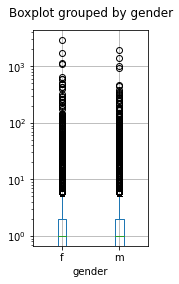

In [69]:
fig, ax = plt.subplots(figsize=(2,4))
plt.suptitle('')
data_recrawled.boxplot(column=['new_like_count'], by='gender', ax=ax)
ax.set_yscale('log')
ax.set_title('')

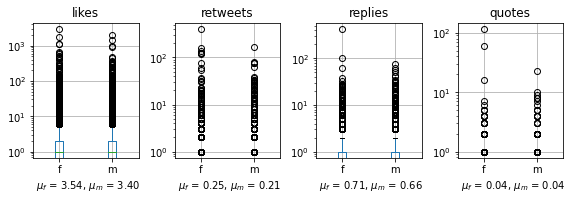

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8,3))
i = 0
names =  ['likes', 'retweets', 'replies', 'quotes']
for col in ['new_like_count', 'new_retweet_count', 'new_reply_count', 'new_quote_count']:
    data_recrawled.boxplot(column=[col], by='gender', ax=axes[i])
    axes[i].set_yscale('log')
    axes[i].set_xlabel('')
    axes[i].set_title(names[i])
    axes[i].set_xlabel(r" $\mu_f$ = " + "{:.2f}".format(data_recrawled.loc[data_recrawled.gender=="f", col].mean()) + \
                       r", $\mu_m$ = " + "{:.2f}".format(data_recrawled.loc[data_recrawled.gender=="m", col].mean()), 
                       position=(0., 1e6), horizontalalignment='left')
    i += 1
fig.suptitle('')
fig.tight_layout(pad=1.0)

In [113]:
fig.savefig('../Gender/figures/response_statistics.png')

In [86]:
for col in ['new_like_count', 'new_retweet_count', 'new_reply_count', 'new_quote_count']:
    print("female")
    print(data_recrawled[data_recrawled.gender=="f"][[col]].describe())
    print("male")
    print(data_recrawled[data_recrawled.gender=="m"][[col]].describe())

female
       new_like_count
count    13338.000000
mean         3.542885
std         36.924338
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max       2978.000000
male
       new_like_count
count    11736.000000
mean         3.404226
std         29.473185
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max       1944.000000
female
       new_retweet_count
count       13338.000000
mean            0.253561
std             4.706824
min             0.000000
25%             0.000000
50%             0.000000
75%             0.000000
max           403.000000
male
       new_retweet_count
count       11736.000000
mean            0.214980
std             2.594915
min             0.000000
25%             0.000000
50%             0.000000
75%             0.000000
max           166.000000
female
       new_reply_count
count     13338.000000
mean          0.706703
std           4.134761
min           0.000000
25%     

In [87]:
scipy.stats.mannwhitneyu(data_recrawled[data_recrawled.gender=="f"][["new_like_count"]], data_recrawled[data_recrawled.gender=="m"][["new_like_count"]])

MannwhitneyuResult(statistic=array([79761606.]), pvalue=array([0.00586629]))

In [88]:
scipy.stats.mannwhitneyu(data_recrawled[data_recrawled.gender=="f"][["new_retweet_count"]], data_recrawled[data_recrawled.gender=="m"][["new_retweet_count"]])

MannwhitneyuResult(statistic=array([78804507.5]), pvalue=array([0.02983003]))

In [89]:
scipy.stats.mannwhitneyu(data_recrawled[data_recrawled.gender=="f"][["new_reply_count"]], data_recrawled[data_recrawled.gender=="m"][["new_reply_count"]])

MannwhitneyuResult(statistic=array([79464193.]), pvalue=array([0.01571821]))

In [90]:
scipy.stats.mannwhitneyu(data_recrawled[data_recrawled.gender=="f"][["new_quote_count"]], data_recrawled[data_recrawled.gender=="m"][["new_quote_count"]])

MannwhitneyuResult(statistic=array([78254167.5]), pvalue=array([0.93105001]))

In [114]:
scipy.stats.spearmanr(data_recrawled.loc[data_recrawled.gender=="f", "new_like_count"], data_recrawled.loc[data_recrawled.gender=="f", "user_followers_count"])

SpearmanrResult(correlation=0.2640314934173556, pvalue=1.433242803947432e-211)

In [115]:
scipy.stats.spearmanr(data_recrawled.loc[data_recrawled.gender=="m", "new_like_count"], data_recrawled.loc[data_recrawled.gender=="m", "user_followers_count"])

SpearmanrResult(correlation=0.2662322917312839, pvalue=1.3175615017067508e-189)

In [116]:
scipy.stats.spearmanr(data_recrawled.loc[data_recrawled.gender=="f", "new_retweet_count"], data_recrawled.loc[data_recrawled.gender=="f", "user_followers_count"])

SpearmanrResult(correlation=0.1319987637624637, pvalue=6.538764175707398e-53)

In [117]:
scipy.stats.spearmanr(data_recrawled.loc[data_recrawled.gender=="m", "new_retweet_count"], data_recrawled.loc[data_recrawled.gender=="m", "user_followers_count"])

SpearmanrResult(correlation=0.15021008966190647, pvalue=3.4639918799205533e-60)

In [118]:
scipy.stats.spearmanr(data_recrawled.loc[data_recrawled.gender=="f", "new_reply_count"], data_recrawled.loc[data_recrawled.gender=="f", "user_followers_count"])

SpearmanrResult(correlation=0.19606780867309223, pvalue=1.0591944926095145e-115)

In [119]:
scipy.stats.spearmanr(data_recrawled.loc[data_recrawled.gender=="m", "new_reply_count"], data_recrawled.loc[data_recrawled.gender=="m", "user_followers_count"])

SpearmanrResult(correlation=0.1871625930580323, pvalue=5.456839599557675e-93)